#mount gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#install library prerequisites

In [ ]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn pillow

#imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, BatchNormalization, LayerNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import mixed_precision

#configuration

In [ ]:
# Configuration
IMG_SIZE = 224
SEQUENCE_LENGTH = 5  # Adjusting for 5 frames per sequence, update as needed
BATCH_SIZE = 8
EPOCHS = 20
DATA_DIR = "/content/drive/My Drive/ASL_to_Text_Project/data"
MODEL_DIR = "/content/drive/My Drive/ASL_to_Text_Project/models"
LABELS_DIR = "/content/drive/My Drive/ASL_to_Text_Project/labels"
RNN_MODEL_PATH = os.path.join(MODEL_DIR, "rnn_asl_model.keras")
RNN_LABEL_PATH = os.path.join(LABELS_DIR, "rnn_label_encoder.pkl")
CHECKPOINT_PATH = os.path.join(MODEL_DIR, "model_checkpoint.keras")

# Create directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LABELS_DIR, exist_ok=True)

#load and preprocess images

In [ ]:
# Load and preprocess image
def load_and_preprocess_image(path):
    try:
        if not os.path.exists(path):
            print(f"Image not found: {path}")
            return None

        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = img_to_array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

# Data Generator

In [ ]:
def data_generator(paths, label_encoder, mode="train"):
    num_samples = len(paths)
    indices = np.arange(num_samples)

    print(f"Generating data in {mode} mode")
    print(f"Total paths: {num_samples}")
    print(f"Label classes: {label_encoder.classes_}")

    while True:
        if mode == "train":
            np.random.shuffle(indices)

        for start_idx in range(0, num_samples, BATCH_SIZE):
            batch_indices = indices[start_idx:start_idx + BATCH_SIZE]
            batch_paths = [paths[i] for i in batch_indices]

            X, y = [], []
            for path in batch_paths:
                sequence = []
                label = path.split('/')[-2]  # Extract the gesture label from the folder name

                # Loop through the frame files (adjust the filename pattern as necessary)
                image_files = sorted([f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))])

                # Ensure there are enough frames (pad if necessary)
                if len(image_files) < SEQUENCE_LENGTH:
                    image_files.extend([None] * (SEQUENCE_LENGTH - len(image_files)))  # Padding with None

                for i in range(SEQUENCE_LENGTH):
                    frame_filename = image_files[i]

                    if frame_filename:
                        frame_path = os.path.join(path, frame_filename)
                        image = load_and_preprocess_image(frame_path)
                    else:
                        # If the image is missing (i.e., padding), create a dummy image (zeros)
                        image = np.zeros((IMG_SIZE, IMG_SIZE, 3))

                    # Apply augmentations if in training mode
                    if mode == "train":
                        image = tf.image.random_brightness(image, 0.2)
                        image = tf.image.random_contrast(image, 0.8, 1.2)
                        if np.random.rand() > 0.5:
                            image = tf.image.flip_left_right(image)

                    sequence.append(image)

                # Add the sequence and the corresponding label to the batch
                if len(sequence) == SEQUENCE_LENGTH:
                    X.append(sequence)
                    y.append(label_encoder.transform([label])[0])  # Convert label to numeric

            if len(X) > 0:
                yield np.array(X), to_categorical(y, num_classes=len(label_encoder.classes_))



# mixed precision

In [ ]:
# Mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Build the RNN model

In [ ]:
# Build the RNN model
def build_model(num_classes, dropout_rate=0.3, l1_reg=1e-5, l2_reg=1e-4):
    model = keras.Sequential([
        # Input layer
        keras.layers.Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3)),

        # Feature extraction layers with L1/L2 regularization
        TimeDistributed(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))),
        TimeDistributed(keras.layers.MaxPooling2D((2, 2))),
        TimeDistributed(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))),
        TimeDistributed(keras.layers.MaxPooling2D((2, 2))),
        TimeDistributed(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))),
        TimeDistributed(keras.layers.MaxPooling2D((2, 2))),
        TimeDistributed(keras.layers.Flatten()),

        # GRU layer with L1/L2 regularization
        GRU(64,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate / 2,
            return_sequences=False,
            kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
            recurrent_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)
        ),

        # Classification layers with L1/L2 regularization
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax', kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))
    ])
    return model

def compile_model(model, learning_rate=0.0005):
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main execution


Total sequences found: 1454
Unique gestures found: 3

Training on 1017 samples
Validating on 218 samples
Generating data in train mode
Total paths: 1017
Label classes: ['No' 'Thank_you' 'Yes']
Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7431 - loss: 5.3126 Generating data in val mode
Total paths: 218
Label classes: ['No' 'Thank_you' 'Yes']

Epoch 1: val_loss improved from inf to 1.18613, saving model to /content/drive/My Drive/ASL_to_Text_Project/models/model_checkpoint.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 3420s 27s/step - accuracy: 0.7444 - loss: 5.2948 - val_accuracy: 1.0000 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9944 - loss: 0.9222
Epoch 2: val_loss improved from 1.18613 to 0.63169, saving model to /content/drive/My Drive/ASL_to_Text_Project/models/model_checkpoint.keras
127/127 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - accuracy: 0.9944 - loss: 0.9213 - val_accuracy: 1.0000 - val_loss: 0.6317 - 

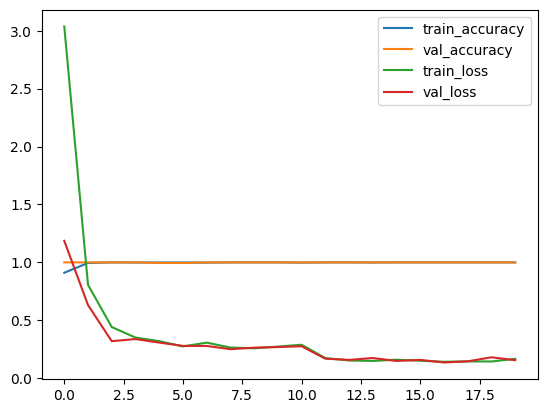

In [ ]:
# Main execution
if __name__ == "__main__":
    # Define gesture categories (update as needed)
    gesture_categories = ['Yes', 'No', 'Thank_you']  # Example gestures, update with real ones

    # Load data paths and labels
    all_paths, labels = [], []
    for gesture in gesture_categories:
        gesture_dir = os.path.join(DATA_DIR, "gesture_sequences", gesture)
        if not os.path.isdir(gesture_dir):
            print(f"Gesture directory not found: {gesture_dir}")
            continue

        for sequence_dir in os.listdir(gesture_dir):
            sequence_path = os.path.join(gesture_dir, sequence_dir)
            if os.path.isdir(sequence_path):
                # Ensure the sequence folder contains images (e.g., .jpg, .png)
                image_files = [f for f in os.listdir(sequence_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                if not image_files:
                    print(f"No image files found in sequence: {sequence_path}")
                    continue

                # Add the sequence path and label
                all_paths.append(sequence_path)
                labels.append(gesture)

    print(f"\nTotal sequences found: {len(all_paths)}")
    print(f"Unique gestures found: {len(set(labels))}")

    # Create label encoder
    label_encoder = LabelEncoder()
    label_encoder.fit(gesture_categories)
    num_classes = len(label_encoder.classes_)

    # Split data
    train_paths, temp_paths = train_test_split(all_paths, test_size=0.3, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

    # Create generators
    train_generator = data_generator(train_paths, label_encoder)
    val_generator = data_generator(val_paths, label_encoder, mode="val")

    train_steps = max(1, len(train_paths) // BATCH_SIZE)
    val_steps = max(1, len(val_paths) // BATCH_SIZE)

    print(f"\nTraining on {len(train_paths)} samples")
    print(f"Validating on {len(val_paths)} samples")

    # Build and compile model
    model = build_model(num_classes, dropout_rate=0.3, l1_reg=1e-4, l2_reg=1e-3)
    model = compile_model(model, learning_rate=0.001)

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=callbacks
    )

    # Save the model and label encoder
    model.save(RNN_MODEL_PATH)
    with open(RNN_LABEL_PATH, "wb") as f:
        pickle.dump(label_encoder, f)

    # Plot accuracy and loss
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()
